# Benchmark Model - Straight Line long-only strategy 

This benchmark model simulates the revenue and execution costs of a simple long-only strategy in which a trader breaks the block being executed into equal sized blocks over equal time intervals. Note that as the order book data only provides the first 100 orders, so we need to set the initial capital carefully for strategy to work.

## Initial capital = $100M
## Interval = 15 minutes

In [231]:
import pandas as pd
import numpy as np
import functools
from datetime import datetime, timedelta
from coinmetrics.api_client import CoinMetricsClient
import pprint
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from datetime import datetime
pd.set_option('display.float_format', lambda x: '%.5f' % x)

client = CoinMetricsClient('FeHRFvBh9VfW6an1UgbM')

# Data

In [232]:
df = pd.read_pickle("orderbooks_coinbase_ETH_USD_1642179610536_1654522174527.pickle")

In [233]:
df_new = {}
observation_times = []
for key in df.keys():
    
    # Change timestamp into %Y-%m-%d %H:%M:%S form
    timestamp = datetime.fromtimestamp(int(key)/1000)
    timestamp = timestamp.strftime("%Y-%m-%d %H:%M:%S")
    observation_times.append(timestamp)
    
    # Generate askbook and bidbook
    askbook = pd.DataFrame(df[key]["data"]["asks"])
    
    # Drop all the timestamps that there is no data
    if len(askbook.columns) != 2:
        continue
    
    askbook.columns = ["price","quantity"]     
    askbook["notional"] = askbook["price"] * askbook["quantity"]
    bidbook = pd.DataFrame(df[key]["data"]["bids"])
    bidbook.columns = ["price","quantity"]
    bidbook["notional"] = bidbook["price"] * bidbook["quantity"]
    
    # Create a dictionary with keys as time and values as order books
    df_new[int(key)] = [askbook, bidbook]
df_new

{1642179610536: [        price  quantity    notional
  0  3295.97000   0.54408  1793.26256
  1  3295.98000   0.15446   509.10439
  2  3296.12000   7.58763 25009.73890
  3  3296.13000   0.46014  1516.68353
  4  3296.15000   0.79138  2608.49351
  ..        ...       ...         ...
  95 3301.88000   2.34807  7753.06026
  96 3301.90000   0.00390    12.86258
  97 3301.95000   0.00113     3.72027
  98 3301.97000   0.00041     1.34889
  99 3301.99000   0.00426    14.07942
  
  [100 rows x 3 columns],
          price  quantity   notional
  0  3295.55000   0.79326 2614.23063
  1  3295.54000   0.68361 2252.86436
  2  3295.53000   0.76811 2531.32217
  3  3295.52000   0.74759 2463.70228
  4  3295.51000   0.00100    3.29551
  ..        ...       ...        ...
  95 3287.97000   0.00131    4.31694
  96 3287.76000   0.15000  493.16400
  97 3287.57000   0.29000  953.39530
  98 3287.21000   0.84983 2793.57526
  99 3287.20000   0.15000  493.08000
  
  [100 rows x 3 columns]],
 1642179880786: [        p

In [234]:
start_time = observation_times[0]
end_time =  observation_times[-1]
print(f"start time is {start_time} and end time is {end_time}")

start time is 2022-01-14 11:00:10 and end time is 2022-06-06 08:29:34


## Trading Cost

In [238]:
# Calculate the trading taker fees
def trading_cost(notional):
    if notional < 1e4:
        pct = 0.6
    elif notional < 5*1e4:
        pct = 0.4
    elif notional < 1e5:
        pct = 0.25
    elif notional < 1e6:
        pct = 0.2
    elif notional < 2*1e7:
        pct = 0.18
    elif notional < 1e8:
        pct = 0.15
    elif notional < 3*1e8:
        pct = 0.1
    elif notional < 5*1e8:
        pct = 0.08
    else:
        pct = 0.05
    return notional*pct/100

## Trading Strategy

Simple long-only strategy in which a trader breaks the block being executed into equal sized blocks over equal time intervals. Here we consider an interval of h_hour.

In [239]:
# Here we use an example of 15 minutes
h_hour = 0.25

# Transfer the time into 13 digit unixtime timestamp in milliseconds
interval = h_hour * 60 * 60000
start, end = list(df_new.keys())[0], list(df_new.keys())[-1]
numtrades = int(np.floor((end - start)/interval))

# Make a bid order every h_hour time
tradetimes = [int(start + interval*i) for i in range(numtrades+1)]
tradetimes[-10:]

[1654513210536,
 1654514110536,
 1654515010536,
 1654515910536,
 1654516810536,
 1654517710536,
 1654518610536,
 1654519510536,
 1654520410536,
 1654521310536]

In [240]:
# Select all the relevant orderbooks
ob_times = list(df_new.keys())
selected_ob = []
i, j = 0, 0
while i < len(tradetimes) and j < len(ob_times)-1:
    if ob_times[j] <= tradetimes[i] and ob_times[j+1] > tradetimes[i]:
        selected_ob.append(ob_times[j])
        i += 1
    else:
        j += 1
selected_ob[-10:]

[1654512892020,
 1654514093682,
 1654514994979,
 1654515895775,
 1654516496479,
 1654517697863,
 1654518599646,
 1654519470487,
 1654520402462,
 1654521273458]

In [255]:
# Construct trading strategy
Initial_capital = 1e8
capital = 1e8/numtrades
tokens_bought = []
for i in range(len(selected_ob)):
    bidbook = df_new[selected_ob[i]][1]
    cap = 1e8/numtrades
    tokens = 0
    i = 0
    while cap > 0 and i < 100:
        cap -= bidbook.iloc[i, 2]
        tokens += bidbook.iloc[i, 1]
        i += 1
    tokens -= (-cap) / bidbook.iloc[i-1, 0]
    tokens_bought.append(tokens)

Now we sell all of the tokens bought before at the end and calculate the final payoff. The trading cost is the same each time, as we are 

Text(0, 0.5, 'Number of tokens bought')

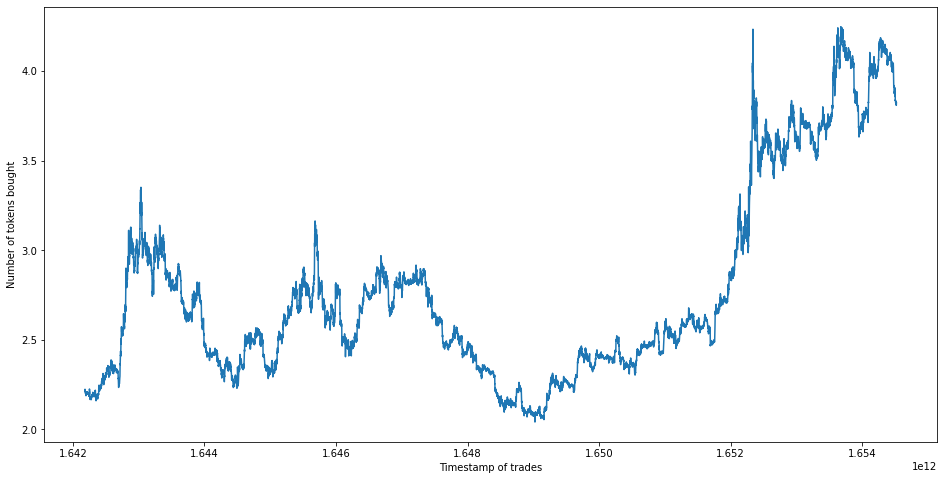

In [274]:
# Number of tokens bought
total_tokens = np.sum(tokens_bought)
plt.figure(figsize=(16,8))
plt.plot(selected_ob, tokens_bought)
plt.xlabel('Timestamp of trades')
plt.ylabel('Number of tokens bought')

In [265]:
# Trading cost
total_trading_cost = trading_cost(capital) * numtrades
total_trading_cost

600000.0

In [266]:
# Selling all the bought tokens
revenue = 0
askbook = df_new[end][0]
i = 0
while total_tokens > 0 and i < 100:
    total_tokens -= askbook.iloc[i, 1]
    revenue += bidbook.iloc[i, 2]
    i += 1
revenue -= (-total_tokens)*askbook.iloc[i-1, 0]
revenue

71862127.16549002

In [269]:
# Final Payoff = Revenue - Trading cost
payoff = revenue - total_trading_cost
pct_return = (payoff - Initial_capital) / Initial_capital
pct_return

-0.2873787283450998

If we follow this simple strategy with initial capital = 1e8 and trading interval = 15 minutes, then the return rate (with trading cost being subtracted) is -28.7%, and the trading cost is 600,000 dollar.